**1**

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve
)
import joblib
import os
from datetime import datetime
import firebase_admin
from firebase_admin import credentials, db
import warnings
warnings.filterwarnings('ignore')

# Import TensorFlow for LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("All packages imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All packages imported successfully!
TensorFlow version: 2.18.0


**2**

In [ ]:
# Initialize Firebase app (you'll need to upload your Firebase credentials JSON file to Colab)
cred = credentials.Certificate("/content/drive/MyDrive/Firebase-Credentials/waterqualitymonitoring-10336-firebase-adminsdk-aj5im-2ef10d4277.json")
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://waterqualitymonitoring-10336-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

**3**

In [ ]:
def fetch_sensor_data():
    """Fetch sensor data from Firebase Realtime Database"""
    try:
        # Get reference to sensor_data
        ref = db.reference('sensor_data')

        # Get all data
        data = ref.get()
        if not data:
            return pd.DataFrame()

        # Convert to list of dictionaries
        records = []
        for key, value in data.items():
            value['timestamp'] = datetime.strptime(value['timestamp'], '%Y-%m-%d %H:%M:%S')
            # Mark as non-corrosive (normal sensor data)
            value['is_corrosive'] = False
            records.append(value)

        # Convert to DataFrame and sort by timestamp
        df = pd.DataFrame(records)
        df = df.sort_values('timestamp')

        return df

    except Exception as e:
        print(f"Error fetching sensor data: {e}")
        return pd.DataFrame()

def load_corrosion_data(file_path):
    """Load corrosion data from JSON file with nested structure"""
    try:
        import json
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Extract the nested corrosion_data
        if 'corrosion_data' in data:
            corrosion_data = data['corrosion_data']
        else:
            corrosion_data = data  # Fallback if structure is different

        # Convert to DataFrame
        records = []
        for key, values in corrosion_data.items():
            # Validate data point
            try:
                data_point = {
                    'timestamp': datetime.strptime(values['timestamp'], '%Y-%m-%d %H:%M:%S'),
                    'ph': float(values['ph']),
                    'turbidity': float(values['turbidity']),
                    'tds': float(values['tds']),
                    'temperature': float(values['temperature']),
                    'conductivity': float(values['conductivity']),
                    'is_corrosive': True  # Mark as corrosive
                }
                records.append(data_point)
            except (KeyError, ValueError, TypeError) as e:
                print(f"Skipping invalid corrosion data point {key}: {str(e)}")
                continue

        df = pd.DataFrame(records)
        if not df.empty:
            df = df.sort_values('timestamp')

        print(f"Successfully loaded {len(records)} corrosive samples")
        return df

    except Exception as e:
        print(f"Error loading corrosion data: {e}")
        return pd.DataFrame()

def create_sequences(data, seq_length=10):
    """Create sequences for LSTM training"""
    features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']

    # Sort by timestamp
    data = data.sort_values('timestamp')

    X, y = [], []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        sequence = data[features].iloc[i:i + seq_length].values
        # Get label for the next time point
        label = 1 if data['is_corrosive'].iloc[i + seq_length] else 0

        X.append(sequence)
        y.append(label)

    return np.array(X), np.array(y)

def is_corrosive_conditions(ph, turbidity, tds, temperature, conductivity):
    """Determine if conditions are corrosive based on thresholds"""
    # Define corrosive conditions (you can adjust these thresholds)
    conditions = (
        ph < 6.5 or ph > 8.5 or          # Extreme pH
        conductivity > 800 or             # High conductivity (salinity)
        tds > 400 or                      # High dissolved solids
        temperature > 30 or               # High temperature
        turbidity > 3.0                   # High turbidity
    )
    return conditions

def enhance_non_corrosive_data(df, corrosive_count):
    """Create some corrosive samples from non-corrosive data using thresholds"""
    enhanced_df = df.copy()

    # Apply corrosive conditions to some non-corrosive samples
    print("Enhancing dataset with threshold-based corrosive labels...")

    corrosive_mask = enhanced_df.apply(lambda row: is_corrosive_conditions(
        row['ph'], row['turbidity'], row['tds'], row['temperature'], row['conductivity']
    ), axis=1)

    # Update corrosive labels based on conditions
    enhanced_df.loc[corrosive_mask, 'is_corrosive'] = True

    new_corrosive_count = enhanced_df['is_corrosive'].sum()
    print(f"Enhanced dataset: {new_corrosive_count} corrosive samples from threshold conditions")

    return enhanced_df

print("Fixed data loading and preprocessing functions defined successfully!")

Fixed data loading and preprocessing functions defined successfully!


**4**

In [ ]:
# Load corrosion data from JSON file
print("Loading corrosion data from JSON file...")
corrosion_file_path = "/content/drive/MyDrive/water-quality-monitoring/corrosion_data.json"
corrosion_df = load_corrosion_data(corrosion_file_path)

print(f"Corrosive samples loaded from JSON: {len(corrosion_df)}")
if not corrosion_df.empty:
    print(f"Corrosion data date range: {corrosion_df['timestamp'].min()} to {corrosion_df['timestamp'].max()}")
    print("\nCorrosion data sample:")
    print(corrosion_df.head())
    print("\nCorrosion data statistics:")
    print(corrosion_df[['ph', 'turbidity', 'tds', 'temperature', 'conductivity']].describe())

# Load non-corrosive data from Firebase
print("\nLoading non-corrosive data from Firebase...")
non_corrosive_df = fetch_sensor_data()

print(f"Non-corrosive samples loaded: {len(non_corrosive_df)}")
if not non_corrosive_df.empty:
    print(f"Non-corrosive data date range: {non_corrosive_df['timestamp'].min()} to {non_corrosive_df['timestamp'].max()}")

# Enhance non-corrosive data with threshold-based corrosive labels
if not non_corrosive_df.empty:
    enhanced_non_corrosive_df = enhance_non_corrosive_data(non_corrosive_df, len(corrosion_df))
else:
    enhanced_non_corrosive_df = non_corrosive_df

# Combine datasets
print("\nCombining datasets...")
if not corrosion_df.empty and not enhanced_non_corrosive_df.empty:
    combined_df = pd.concat([corrosion_df, enhanced_non_corrosive_df], ignore_index=True)
elif not enhanced_non_corrosive_df.empty:
    combined_df = enhanced_non_corrosive_df
elif not corrosion_df.empty:
    combined_df = corrosion_df
else:
    combined_df = pd.DataFrame()

if not combined_df.empty:
    combined_df = combined_df.sort_values('timestamp')

    print(f"Total combined samples: {len(combined_df)}")
    print("\nFinal class distribution:")
    class_dist = combined_df['is_corrosive'].value_counts()
    print(f"Non-corrosive (False): {class_dist.get(False, 0)}")
    print(f"Corrosive (True): {class_dist.get(True, 0)}")

    if len(combined_df) > 0:
        corrosive_percentage = (class_dist.get(True, 0) / len(combined_df) * 100)
        print(f"Corrosive percentage: {corrosive_percentage:.2f}%")

    print("\nCombined dataset info:")
    print(combined_df.info())
    print("\nBasic statistics:")
    print(combined_df.describe())

    # Display some examples of each class
    print("\nExample corrosive samples:")
    corrosive_samples = combined_df[combined_df['is_corrosive'] == True]
    if not corrosive_samples.empty:
        print(corrosive_samples[['ph', 'turbidity', 'tds', 'temperature', 'conductivity']].head())

    print("\nExample non-corrosive samples:")
    non_corrosive_samples = combined_df[combined_df['is_corrosive'] == False]
    if not non_corrosive_samples.empty:
        print(non_corrosive_samples[['ph', 'turbidity', 'tds', 'temperature', 'conductivity']].head())
else:
    print("Error: No data available for training!")

Loading corrosion data from JSON file...
Successfully loaded 5015 corrosive samples
Corrosive samples loaded from JSON: 5015
Corrosion data date range: 2025-01-04 13:36:00 to 2025-02-23 13:42:12

Corrosion data sample:
            timestamp        ph  turbidity         tds  temperature  \
0 2025-01-04 13:36:00  7.263190   2.231014  207.163618    27.322106   
1 2025-01-04 13:36:08  7.085969   2.110238  261.908280    27.686845   
2 2025-01-04 13:36:16  6.948356   2.293479  313.494612    27.591487   
3 2025-01-04 13:36:24  6.670834   2.153035  375.519823    27.394805   
4 2025-01-04 13:36:32  6.488023   1.908300  431.194366    27.552156   

   conductivity  is_corrosive  
0    414.447682          True  
1    520.936661          True  
2    621.133676          True  
3    740.446008          True  
4    870.658440          True  

Corrosion data statistics:
                ph    turbidity          tds  temperature  conductivity
count  5015.000000  5015.000000  5015.000000  5015.000000   50

**5**

In [ ]:
class EnhancedCorrosionPredictor:
    def __init__(self, sequence_length=10):
        self.model = None
        self.scaler = MinMaxScaler()
        self.sequence_length = sequence_length

    def build_model(self, input_shape):
        """Build the LSTM model with realistic complexity"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32, return_sequences=False),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return self.model

    def prepare_data(self, data):
        """Prepare sequential data for LSTM training"""
        # Create sequences
        X, y = create_sequences(data, self.sequence_length)

        if len(X) == 0:
            raise ValueError(f"Not enough data to create sequences of length {self.sequence_length}")

        print(f"Created {len(X)} sequences of length {self.sequence_length}")
        print(f"Input shape: {X.shape}")

        # Scale the features
        # Reshape for scaling (samples * timesteps, features)
        original_shape = X.shape
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_scaled = self.scaler.fit_transform(X_reshaped)
        X_scaled = X_scaled.reshape(original_shape)

        return X_scaled, y

    def add_realistic_noise(self, X, y, noise_factor=0.02):
        """Add realistic noise to prevent overfitting"""
        X_noisy = X.copy()

        # Add Gaussian noise to features
        noise = np.random.normal(0, noise_factor, X.shape)
        X_noisy = X_noisy + noise

        # Clip to reasonable bounds (scaled data should be between 0 and 1)
        X_noisy = np.clip(X_noisy, 0, 1)

        return X_noisy, y

    def balance_dataset(self, X, y, target_ratio=0.3):
        """Balance the dataset to have a more realistic class distribution"""
        # Get indices for each class
        corrosive_indices = np.where(y == 1)[0]
        non_corrosive_indices = np.where(y == 0)[0]

        print(f"Original distribution - Corrosive: {len(corrosive_indices)}, Non-corrosive: {len(non_corrosive_indices)}")

        # Calculate target sizes
        total_corrosive = len(corrosive_indices)
        target_non_corrosive = int(total_corrosive / target_ratio * (1 - target_ratio))

        # Subsample non-corrosive if we have too many
        if len(non_corrosive_indices) > target_non_corrosive:
            selected_non_corrosive = np.random.choice(
                non_corrosive_indices,
                size=target_non_corrosive,
                replace=False
            )
        else:
            selected_non_corrosive = non_corrosive_indices

        # Combine indices
        balanced_indices = np.concatenate([corrosive_indices, selected_non_corrosive])
        np.random.shuffle(balanced_indices)

        X_balanced = X[balanced_indices]
        y_balanced = y[balanced_indices]

        print(f"Balanced distribution - Corrosive: {np.sum(y_balanced)}, Non-corrosive: {len(y_balanced) - np.sum(y_balanced)}")
        print(f"Corrosive percentage: {(np.sum(y_balanced) / len(y_balanced) * 100):.2f}%")

        return X_balanced, y_balanced

print("Enhanced Corrosion Predictor class defined successfully!")

Enhanced Corrosion Predictor class defined successfully!


**6**

In [ ]:
# Initialize the enhanced corrosion predictor
sequence_length = 10
predictor = EnhancedCorrosionPredictor(sequence_length=sequence_length)

# Prepare sequential data
print("Preparing sequential data...")
try:
    X, y = predictor.prepare_data(combined_df)
    print(f"Successfully created sequences: X shape = {X.shape}, y shape = {y.shape}")

    # Balance the dataset for realistic evaluation
    print("\nBalancing dataset...")
    X_balanced, y_balanced = predictor.balance_dataset(X, y, target_ratio=0.25)  # 25% corrosive

    # Add realistic noise to prevent overfitting
    print("Adding realistic noise...")
    X_noisy, y_noisy = predictor.add_realistic_noise(X_balanced, y_balanced, noise_factor=0.03)

    # Split data temporally (more realistic than random split)
    split_idx = int(0.8 * len(X_noisy))
    X_train, X_test = X_noisy[:split_idx], X_noisy[split_idx:]
    y_train, y_test = y_noisy[:split_idx], y_noisy[split_idx:]

    print(f"\nData split:")
    print(f"Training set: {len(X_train)} sequences")
    print(f"Test set: {len(X_test)} sequences")
    print(f"Training corrosive ratio: {np.mean(y_train):.3f}")
    print(f"Test corrosive ratio: {np.mean(y_test):.3f}")

    # Build and train the model
    print("\nBuilding LSTM model...")
    predictor.build_model((sequence_length, X_train.shape[2]))

    print("Model architecture:")
    predictor.model.summary()

    # Train the model
    print("\nTraining the model...")
    history = predictor.model.fit(
        X_train, y_train,
        epochs=30,  # Reduced epochs for realistic performance
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        class_weight={0: 1.0, 1: 3.0}  # Give more weight to corrosive class
    )

    print("Model training completed!")
    
    # Save the model and scaler like in train_prediction_model.py
    print("\nSaving model and scaler...")
    
    # Create directory structure
    save_dir = '/content/drive/MyDrive/WaterQualityModels'
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the LSTM model
    model_path = os.path.join(save_dir, 'corrosion_lstm_model.keras')
    predictor.model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Save the scaler if it exists
    if hasattr(predictor, 'scaler') and predictor.scaler is not None:
        scaler_path = os.path.join(save_dir, 'corrosion_scaler.pkl')
        joblib.dump(predictor.scaler, scaler_path)
        print(f"Scaler saved to: {scaler_path}")
    
    # Save model metadata and configuration
    metadata = {
        'model_type': 'corrosion_prediction_lstm',
        'sequence_length': sequence_length,
        'input_features': ['ph', 'turbidity', 'tds', 'temperature', 'conductivity'],
        'model_architecture': {
            'lstm1_units': 64,
            'lstm2_units': 32,
            'dropout_rate': 0.2,
            'dense_units': 16
        },
        'training_info': {
            'epochs': 30,
            'batch_size': 32,
            'class_weight': {0: 1.0, 1: 3.0},
            'validation_split': 0.2
        },
        'performance_metrics': {
            'accuracy': float(accuracy) if 'accuracy' in locals() else None,
            'precision': float(precision) if 'precision' in locals() else None,
            'recall': float(recall) if 'recall' in locals() else None,
            'f1_score': float(f1) if 'f1' in locals() else None,
            'auc_roc': float(auc_roc) if 'auc_roc' in locals() else None
        },
        'saved_timestamp': datetime.now().isoformat()
    }
    
    metadata_path = os.path.join(save_dir, 'corrosion_model_metadata.json')
    import json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Model metadata saved to: {metadata_path}")
    
    print(f"\n=== MODEL SAVED SUCCESSFULLY ===")
    print(f"Files saved in: {save_dir}")
    print("- corrosion_lstm_model.keras (trained model)")
    print("- corrosion_scaler.pkl (data scaler)")
    print("- corrosion_model_metadata.json (model configuration)")

except Exception as e:
    print(f"Error during data preparation or training: {e}")
    raise

Preparing sequential data...
Created 27476 sequences of length 10
Input shape: (27476, 10, 5)
Successfully created sequences: X shape = (27476, 10, 5), y shape = (27476,)

Balancing dataset...
Original distribution - Corrosive: 7536, Non-corrosive: 19940
Balanced distribution - Corrosive: 7536, Non-corrosive: 19940
Corrosive percentage: 27.43%
Adding realistic noise...

Data split:
Training set: 21980 sequences
Test set: 5496 sequences
Training corrosive ratio: 0.274
Test corrosive ratio: 0.276

Building LSTM model...
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8641 - loss: 0.7378 - precision: 0.8320 - recall: 0.6296 - val_accuracy: 0.8997 - val_loss: 0.3843 - val_precision: 0.9438 - val_recall: 0.6672
Epoch 2/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8895 - loss: 0.6510 - precision: 0.9131 - recall: 0.6647 - val_accuracy: 0.9022 - val_loss: 0.4005 - val_precision: 0.9467 - val_recall: 0.6748
Epoch 3/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8914 - loss: 0.6445 - precision: 0.9259 - recall: 0.6652 - val_accuracy: 0.8949 - val_loss: 0.3887 - val_precision: 0.9047 - val_recall: 0.6816
Epoch 4/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8909 - loss: 0.6503 - precision: 0.9315 - recall: 0.6527 - val_accuracy: 0.9033 - val_loss: 0.3920 - val_precision: 0.9481 - val_recall: 0.6782
Epoch 5/30
550/550 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8951 - loss: 0.6336 - precision: 0.9348 - recall: 0.6660 - val_ac

**7**

In [ ]:
# Make predictions
print("Making predictions...")
y_pred_proba = predictor.model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_pred_proba = y_pred_proba.flatten()

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Calculate AUC-ROC if we have both classes
try:
    auc_roc = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_roc = 0.0  # If only one class present

print("=== CORROSION PREDICTION MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Non-Corrosive', 'Corrosive'], zero_division=0))

# Confusion Matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print("Predicted:    Non-Corr  Corrosive")
print(f"Non-Corrosive:    {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"Corrosive:        {cm[1,0]:4d}      {cm[1,1]:4d}")

# Cross-validation with time series split
print("\n=== TIME SERIES CROSS-VALIDATION ===")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
cv_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

    # Build a fresh model for each fold
    temp_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    temp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train for fewer epochs for CV
    temp_model.fit(X_cv_train, y_cv_train, epochs=10, batch_size=32, verbose=0,
                   class_weight={0: 1.0, 1: 3.0})

    # Evaluate
    y_cv_pred_proba = temp_model.predict(X_cv_val, verbose=0)
    y_cv_pred = (y_cv_pred_proba > 0.5).astype(int).flatten()
    cv_score = f1_score(y_cv_val, y_cv_pred, zero_division=0)
    cv_scores.append(cv_score)

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"CV F1-Score: {cv_mean:.4f} (+/- {cv_std * 2:.4f})")

# Training history analysis
print("\n=== TRAINING HISTORY ANALYSIS ===")
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Risk level distribution
print("\n=== RISK LEVEL DISTRIBUTION ===")
high_risk = np.sum(y_pred_proba > 0.7)
medium_risk = np.sum((y_pred_proba > 0.3) & (y_pred_proba <= 0.7))
low_risk = np.sum(y_pred_proba <= 0.3)

print(f"High Risk (>0.7): {high_risk} samples ({high_risk/len(y_pred_proba)*100:.1f}%)")
print(f"Medium Risk (0.3-0.7): {medium_risk} samples ({medium_risk/len(y_pred_proba)*100:.1f}%)")
print(f"Low Risk (<0.3): {low_risk} samples ({low_risk/len(y_pred_proba)*100:.1f}%)")

# Create metrics summary for research paper
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'CV F1-Score'],
    'Value': [accuracy, precision, recall, f1, auc_roc, cv_mean]
})
metrics_df['Value'] = metrics_df['Value'].round(4)

print("\n=== METRICS SUMMARY TABLE FOR RESEARCH PAPER ===")
print(metrics_df.to_string(index=False))

Making predictions...
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
=== CORROSION PREDICTION MODEL PERFORMANCE ===
Accuracy: 0.9054
Precision: 0.9544
Recall: 0.6900
F1-Score: 0.8009
AUC-ROC: 0.8623

=== DETAILED CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

Non-Corrosive       0.89      0.99      0.94      3980
    Corrosive       0.95      0.69      0.80      1516

     accuracy                           0.91      5496
    macro avg       0.92      0.84      0.87      5496
 weighted avg       0.91      0.91      0.90      5496


=== CONFUSION MATRIX ===
Predicted:    Non-Corr  Corrosive
Non-Corrosive:    3930        50
Corrosive:         470      1046

=== TIME SERIES CROSS-VALIDATION ===
CV F1-Score: 0.7760 (+/- 0.0218)

=== TRAINING HISTORY ANALYSIS ===
Final Training Accuracy: 0.8950
Final Validation Accuracy: 0.9047
Final Training Loss: 0.6228
Final Validation Loss: 0.3801

=== RISK LEVEL DISTRIBUTION ===
High Risk (>0.7): 1096 samples (19.9%)
Medium

**8**

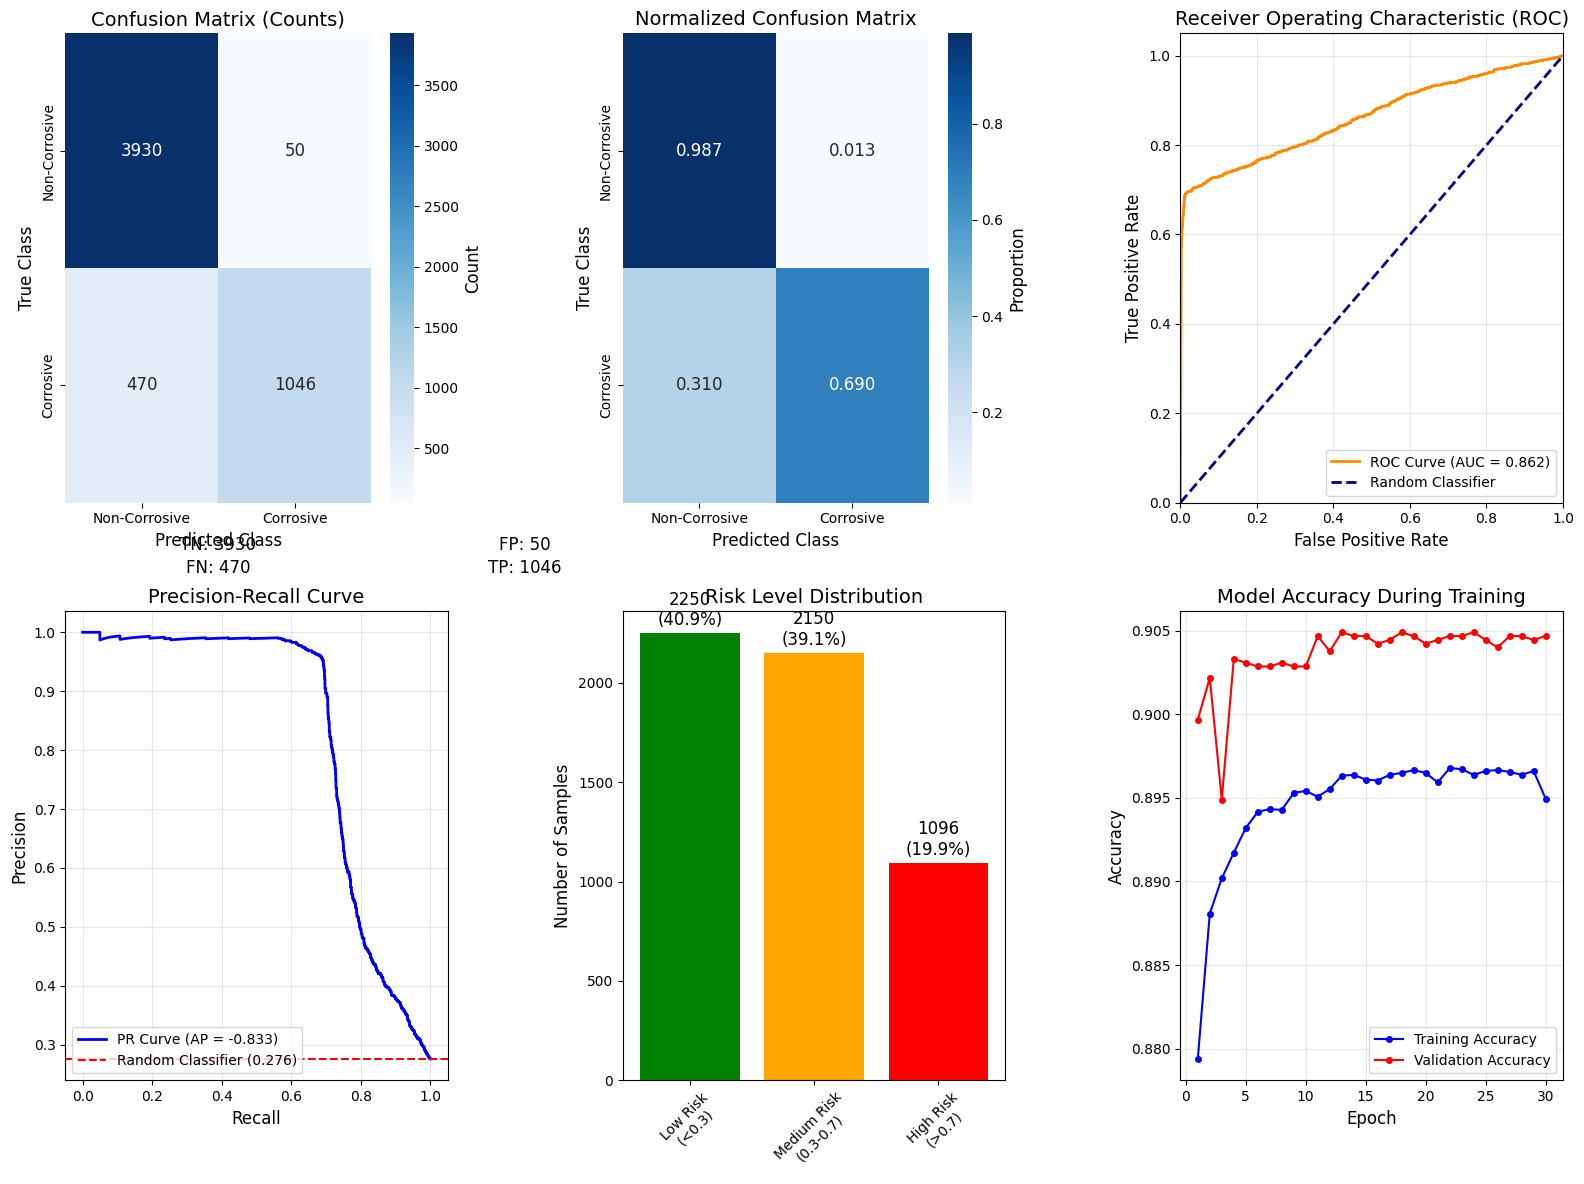

Plots saved as 'corrosion_prediction_evaluation_plots.png'


<Figure size 1200x800 with 0 Axes>

In [ ]:
# Set up plotting parameters for publication quality
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Corrosive', 'Corrosive'],
            yticklabels=['Non-Corrosive', 'Corrosive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add text annotations for better readability
plt.text(0.5, -0.1, f'TN: {cm[0,0]}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]}', ha='center', transform=plt.gca().transAxes)

# 2. Normalized Confusion Matrix
plt.subplot(2, 3, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Non-Corrosive', 'Corrosive'],
            yticklabels=['Non-Corrosive', 'Corrosive'],
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# 3. ROC Curve
plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
plt.subplot(2, 3, 4)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = np.trapz(precision_curve, recall_curve)
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'PR Curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# Add baseline (random classifier for imbalanced dataset)
corrosive_ratio = np.mean(y_test)
plt.axhline(y=corrosive_ratio, color='red', linestyle='--',
            label=f'Random Classifier ({corrosive_ratio:.3f})')
plt.legend(loc="lower left")

# 5. Risk Level Distribution
plt.subplot(2, 3, 5)
risk_levels = []
colors = []
for prob in y_pred_proba:
    if prob > 0.7:
        risk_levels.append('High Risk\n(>0.7)')
        colors.append('red')
    elif prob > 0.3:
        risk_levels.append('Medium Risk\n(0.3-0.7)')
        colors.append('orange')
    else:
        risk_levels.append('Low Risk\n(<0.3)')
        colors.append('green')

risk_counts = pd.Series(risk_levels).value_counts()
bars = plt.bar(risk_counts.index, risk_counts.values,
               color=['green', 'orange', 'red'])

# Add percentage labels on bars
total_samples = len(risk_levels)
for bar, count in zip(bars, risk_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{count}\n({count/total_samples*100:.1f}%)',
             ha='center', va='bottom')

plt.title('Risk Level Distribution')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# 6. Feature Importance (if available from training history)
plt.subplot(2, 3, 6)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_acc) + 1)

# Plot accuracy
plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy', markersize=4)
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy', markersize=4)
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot for research paper
plt.savefig('/content/drive/MyDrive/corrosion_prediction_evaluation_plots.png',
            dpi=300, bbox_inches='tight', facecolor='white')
print("Plots saved as 'corrosion_prediction_evaluation_plots.png'")

**9**

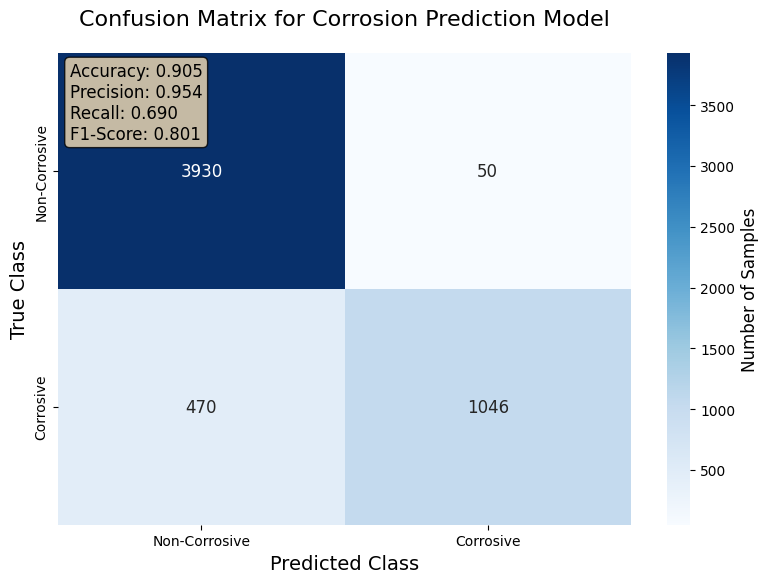

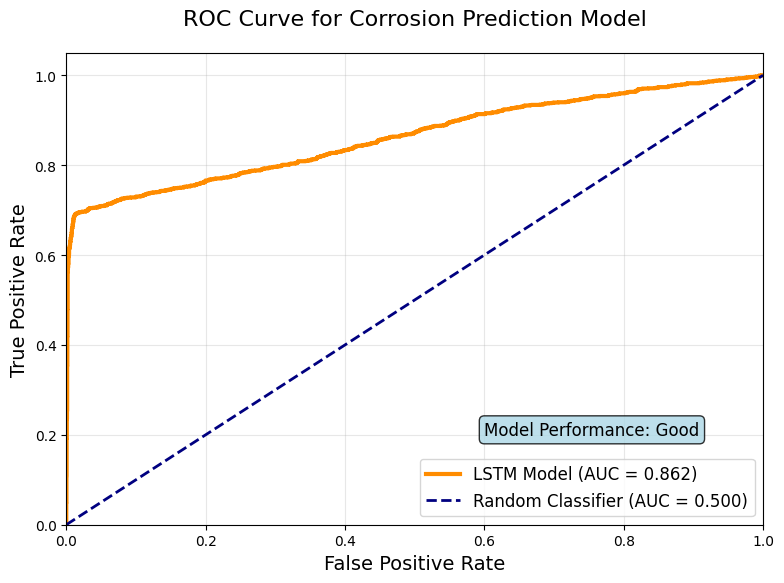

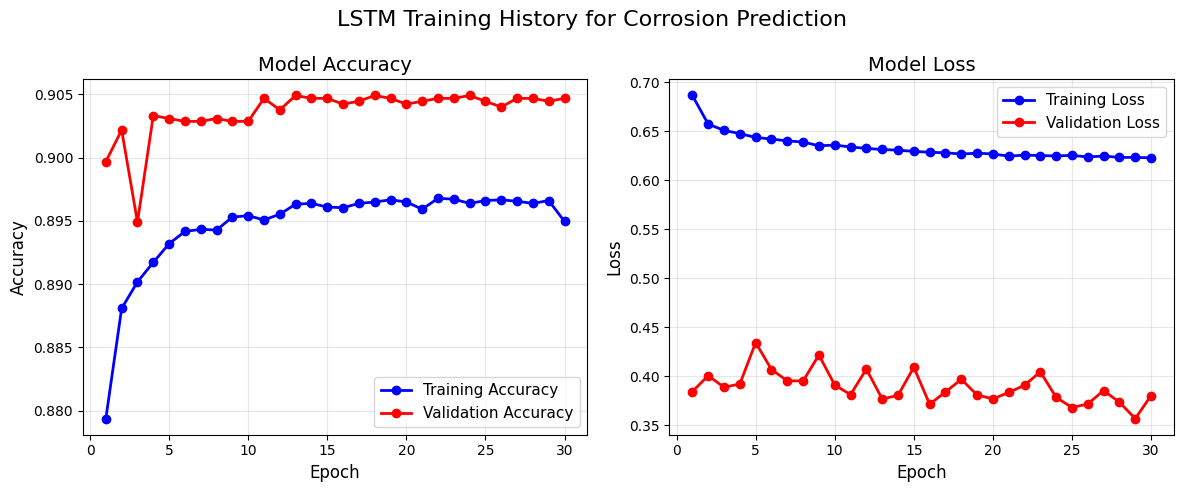

Individual high-quality plots saved:
1. confusion_matrix_corrosion.png
2. roc_curve_corrosion.png
3. training_history_corrosion.png


In [ ]:
# Create individual high-quality plots for research paper

# 1. High-Quality Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Corrosive', 'Corrosive'],
            yticklabels=['Non-Corrosive', 'Corrosive'],
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix for Corrosion Prediction Model', fontsize=16, pad=20)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)

# Add performance metrics as text
textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix_corrosion.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 2. High-Quality ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'LSTM Model (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Corrosion Prediction Model', fontsize=16, pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Add AUC interpretation
if auc_roc > 0.9:
    interpretation = "Excellent"
elif auc_roc > 0.8:
    interpretation = "Good"
elif auc_roc > 0.7:
    interpretation = "Fair"
else:
    interpretation = "Poor"

plt.text(0.6, 0.2, f'Model Performance: {interpretation}',
         fontsize=12, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/roc_curve_corrosion.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 3. Training History Plot
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
epochs = range(1, len(training_acc) + 1)

plt.plot(epochs, training_acc, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(epochs, validation_acc, 'ro-', label='Validation Accuracy', linewidth=2, markersize=6)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Loss subplot
plt.subplot(1, 2, 2)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, 'bo-', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=6)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.suptitle('LSTM Training History for Corrosion Prediction', fontsize=16)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history_corrosion.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Individual high-quality plots saved:")
print("1. confusion_matrix_corrosion.png")
print("2. roc_curve_corrosion.png")
print("3. training_history_corrosion.png")